Imports of stuff we need

In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import to_root

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.20/06


/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.18.5 is currently installed but you installed root_numpy against numpy 1.16.4. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


Load the $B_c^+ \to \tau^+ \nu_\tau$ simulation with $\tau^+ \to 3\pi \nu_\tau$

In [2]:
file_name = "p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU"

file = uproot.open(f"/eos/experiment/fcc/ee/tmp/flatntuples/Z_Zbb_Bc2TauNu/{file_name}.root")
tree = file['events']

Load tree contents into awkward array

In [3]:
events = tree.arrays(library="ak", how="zip")
#tree.show()

Access the reconstructed particles, and match them to their MC partners. Also calculate the separation of the particle production vertices from the PV, used to calculate combined $B_c$ + $\tau$ flight

In [4]:
#Reco particles
rp = events["RP"]

#Index cut to remove negative indices (particles produced before hadronisation)
parentindex_cut = rp["MC_parentindex"] >= 0
rp = rp[parentindex_cut]
grandparentindex_cut = rp["MC_grandparentindex"] >= 0
rp = rp[grandparentindex_cut]

#Match to MC truth partners
rp["parent_pdg"] = events["MC","pdg"][rp["MC_parentindex"]]
rp["grandparent_pdg"] = events["MC","pdg"][rp["MC_grandparentindex"]]
rp["pdg"] = events["MC","pdg"][rp["MC_index"]]

#Get the production vertex of the track
for v in ["x","y","z"]:
    rp[f"vertex_{v}"] = events["MC",f"vertex_{v}"][rp["MC_index"]]

#Get the production vertex of the parent of the tracks (for the pions, this will give the tau production vertex i.e. the Bc decay vertex)
#Will use this Bc vertex in a regressor to learn the Bc lifetime from the ful event info
for v in ["x","y","z"]:
    rp[f"parent_vertex_{v}"] = events["MC",f"vertex_{v}"][rp["MC_parentindex"]]

#Separation of vertex from PV (combined tau and Bc flight)
rp["PVsep"] = np.sqrt(rp[f"vertex_x"]**2 + rp[f"vertex_y"]**2 + rp[f"vertex_z"]**2)

#Separation of the Bc vertex from the PV
rp["PVsep_parent"] = np.sqrt(rp[f"parent_vertex_x"]**2 + rp[f"parent_vertex_y"]**2 + rp[f"parent_vertex_z"]**2)

In [5]:
#Charged tracks to make tau from, will truth match them to pi+/- ID below
p_cut = rp["p"] > 0.
pions = rp[p_cut]

#Keep charged tracks
charge_cut = abs(rp["charge"]) == 1
pions = pions[charge_cut]

Combine three pions to make a $\tau$ candidate, and require correct charge combinations. Also apply truth matching to ensure $\tau$ parent and $B_c$ grandparent.

In [6]:
#Build the tau -> 3pi
tau = ak.combinations(pions,3)
tau["pi_1"], tau["pi_2"], tau["pi_3"] = ak.unzip(tau)

PDG_pi_m = lp.pi_plus.mass/1000.
tau["mass"] = kinematics_flat.mass([tau["pi_1"], tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m, PDG_pi_m])
tau_m_low_cut_val = 3*PDG_pi_m
tau_m_high_cut_val = lp.tau_plus.mass/1000.
tau_m_low_cut = tau["mass"] >= tau_m_low_cut_val
tau_m_high_cut = tau["mass"] <= lp.tau_plus.mass/1000.
tau_m_cut = np.logical_and(tau_m_low_cut, tau_m_high_cut)
tau = tau[tau_m_cut]

#Truth-matching for signal

#Pions are all pions
pi1_cut = abs(tau["pi_1"]["pdg"]) == abs(lp.pi_plus.pdgid)
pi2_cut = abs(tau["pi_2"]["pdg"]) == abs(lp.pi_plus.pdgid)
pi3_cut = abs(tau["pi_3"]["pdg"]) == abs(lp.pi_plus.pdgid)
pi12_cut = np.logical_and(pi1_cut,pi2_cut)
pi_cut_all = np.logical_and(pi12_cut,pi3_cut)
tau = tau[pi_cut_all]

#Pion parents are all tau
tau_parent_cut_pi1 = abs(tau["pi_1"]["parent_pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_pi2 = abs(tau["pi_2"]["parent_pdg"]) == abs(lp.tau_plus.pdgid) 
tau_parent_cut_pi3 = abs(tau["pi_3"]["parent_pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_12 = np.logical_and(tau_parent_cut_pi1, tau_parent_cut_pi2)
tau_parent_cut_all = np.logical_and(tau_parent_cut_12, tau_parent_cut_pi3)
tau = tau[tau_parent_cut_all]

#Pion grandparent are all Bc
tau_grandparent_cut_pi1 = abs(tau["pi_1"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid)
tau_grandparent_cut_pi2 = abs(tau["pi_2"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid) 
tau_grandparent_cut_pi3 = abs(tau["pi_3"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid)
tau_grandparent_cut_12 = np.logical_and(tau_grandparent_cut_pi1, tau_grandparent_cut_pi2)
tau_grandparent_cut_all = np.logical_and(tau_grandparent_cut_12, tau_grandparent_cut_pi3)
tau = tau[tau_grandparent_cut_all]

#Ensure pions come from the same tau
tau_parent_cut_12 = tau["pi_1","MC_parentindex"] == tau["pi_2","MC_parentindex"]
tau_parent_cut_13 = tau["pi_1","MC_parentindex"] == tau["pi_3","MC_parentindex"]
tau_parent_cut = np.logical_and(tau_parent_cut_12, tau_parent_cut_13)
tau = tau[tau_parent_cut]

#Net charge of the tau
tau["charge"] = tau["pi_1","charge"] + tau["pi_2","charge"] + tau["pi_3","charge"]

#Tau energy (visible energy of the signal)
for comp in ["x","y","z"]:
    tau[f"p{comp}"] = tau["pi_1",f"p{comp}"] + tau["pi_2",f"p{comp}"] + tau["pi_1",f"p{comp}"]
tau["p"] = np.sqrt(tau["px"]**2 + tau["py"]**2 + tau["pz"]**2)
tau["e"] = np.sqrt(tau["mass"]**2 + tau["p"]**2)

#Tau flight and Bc flight from PV (using true vertices)
tau["PVsep"] = tau["pi_1","PVsep"]
#x, y, and z coordinates of the tau vertex
for v in ["x","y","z"]:
    tau[f"PVsep_{v}"] = tau["pi_1",f"vertex_{v}"]
tau["PVsep_parent"] = tau["pi_1","PVsep_parent"]

#Thrust axis co-ordinates to persist
for v in ["x","y","z"]:
    tau[f"EVT_thrust_{v}"] = events[f"EVT_thrust_{v}"]

In [7]:
len(ak.flatten(tau["mass"]))

12637

Calculate the total energy in each hemisphere, and split into minimum and maximum hemisphere energies

In [8]:
#Hemisphere energies
for hem in ["0","1"]:
    events[f"EVT_thrutshemis{hem}_e"] = events[f"EVT_thrutshemis{hem}_echarged"] + events[f"EVT_thrutshemis{hem}_eneutral"]

#Total energy (sum of both hemispheres)
events["EVT_e"] = events["EVT_thrutshemis0_e"] + events["EVT_thrutshemis1_e"]

#Min and max hemisphere energies per-event
events["EVT_thrutshemis_e_min"] = np.minimum(events["EVT_thrutshemis0_e"],events["EVT_thrutshemis1_e"])
events["EVT_thrutshemis_e_max"] = np.maximum(events["EVT_thrutshemis0_e"],events["EVT_thrutshemis1_e"])

#Difference in energy between hemispheres (max - min so always positive)
events["EVT_thrutshemis_e_diff"] = events["EVT_thrutshemis_e_max"] - events["EVT_thrutshemis_e_min"]

Plot the energies for the minimum and maximum energy hemispheres

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


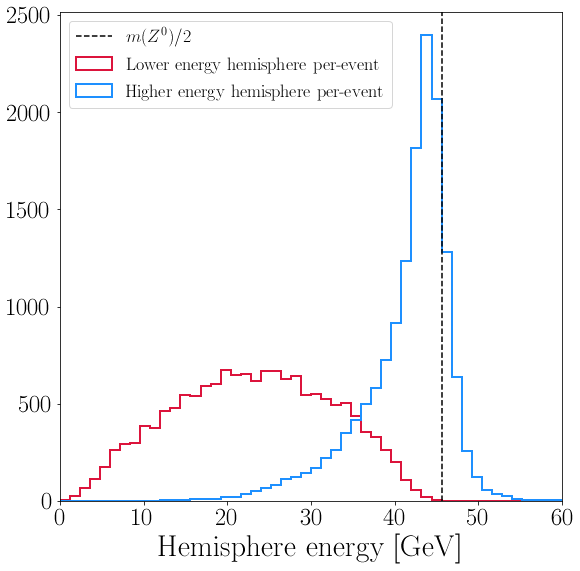

In [9]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(events["EVT_thrutshemis_e_min"],bins=50,range=(0,60),color="crimson",histtype='step',linewidth=2,label="Lower energy hemisphere per-event")
plt.hist(events["EVT_thrutshemis_e_max"],bins=50,range=(0,60),color="dodgerblue",histtype='step',linewidth=2,label="Higher energy hemisphere per-event")
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,60)
plt.axvline(lp.Z_0.mass/2000., color='k',linestyle='--',label="$m(Z^0)/2$")
plt.xlabel("Hemisphere energy [GeV]",fontsize=30)
plt.legend(fontsize=18, loc="upper left")
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_min_max_hemisphere_E.pdf")

Plot the energy difference (max - min) for the two hemispheres

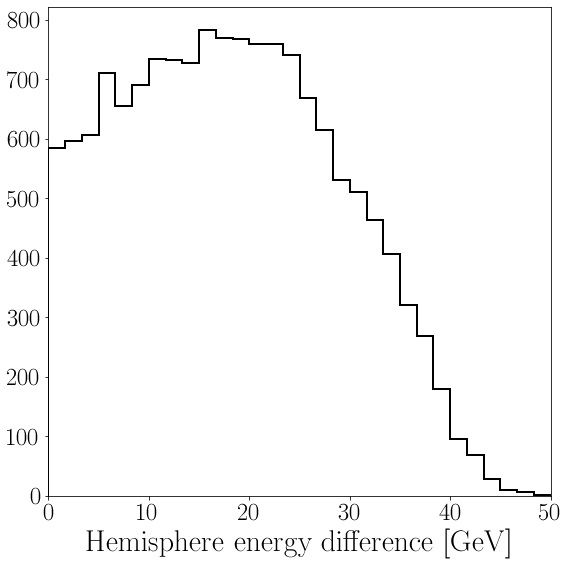

In [10]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(events["EVT_thrutshemis_e_diff"],bins=30,range=(0,50),color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,50)
plt.xlabel("Hemisphere energy difference [GeV]",fontsize=30)
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_diff_hemisphere_E.pdf")

Plot the two hemisphere energies vs. each other. We are plotting hemisphere 0 (opposite thrust axis direction) and hemisphere 1 (along thrust axis direction) here, rather than the min and max energy hemispheres. The plot shows that the two hemispheres are largely independent. 

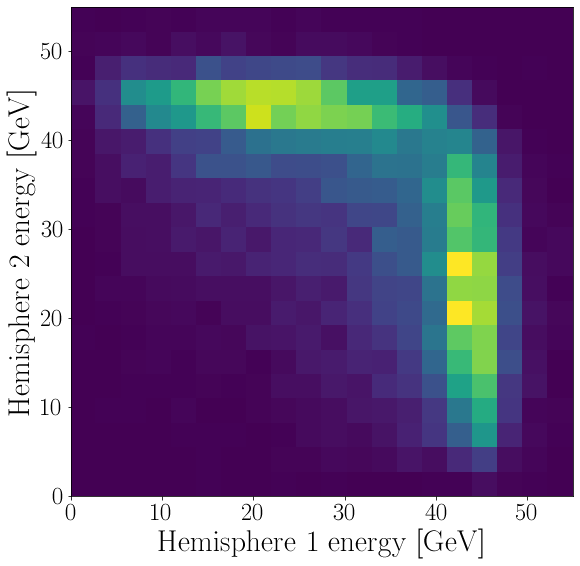

In [11]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist2d(events["EVT_thrutshemis0_e"].tolist(),events["EVT_thrutshemis1_e"].tolist(),bins=20,range=[[0,55],[0,55]])
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,55)
plt.ylim(0,55)
plt.xlabel("Hemisphere 1 energy [GeV]",fontsize=30)
plt.ylabel("Hemisphere 2 energy [GeV]",fontsize=30)
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_hemisphere_E_1_vs_2.pdf")

Persist the hemisphere energy info into $\tau$ container, so we can write it out later

In [12]:
#Store hemisphere energy info in tau container for writing out later
tau["EVT_e"] = events["EVT_e"]
tau["EVT_thrutshemis_e_min"] = events["EVT_thrutshemis_e_min"]
tau["EVT_thrutshemis_e_max"] = events["EVT_thrutshemis_e_max"]
tau["EVT_thrutshemis_e_diff"] = events["EVT_thrutshemis_e_diff"]
tau["EVT_thrutshemis0_e"] = events["EVT_thrutshemis0_e"]
tau["EVT_thrutshemis1_e"] = events["EVT_thrutshemis1_e"]

Calculate the nomimal $B$ energy for each $\tau$ candidate. This is given by $m(Z) - \Sigma$(all of the visible energy in the event apart from the signal $3\pi$). On average this variable will be small for inclsuive $Z \to q\bar{q}$ because the total energy will peak near $m(Z)$. But for signal events with significant missing energy, the distribution is displaced to higher values.

In [13]:
#Nominal B energy = m(Z) - sum of all energy apart from signal
tau["nominal_B_e"] = lp.Z_0.mass/1000. - (tau["EVT_e"] - tau["e"])

Plot the nominal $B$ energy 

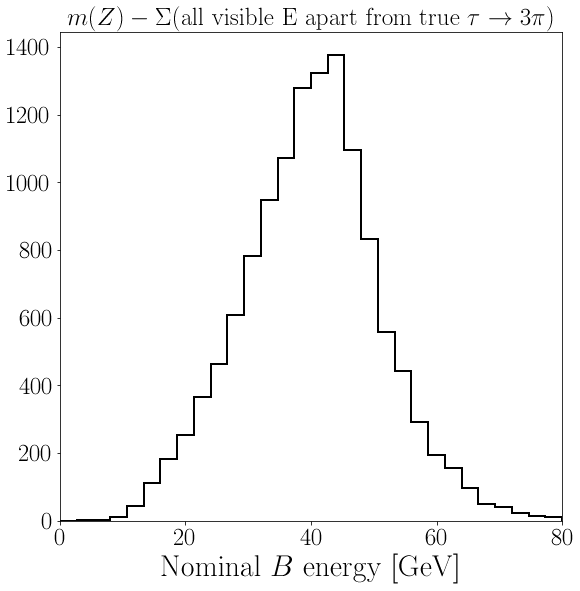

In [14]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(ak.flatten(tau["nominal_B_e"]),range=(0,80),bins=30,color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.title("$m(Z) - \\Sigma$(all visible E apart from true $\\tau \\to 3\\pi$)",fontsize=25)
plt.xlim(0,80)
plt.xlabel("Nominal $B$ energy [GeV]",fontsize=30)
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_nominal_B_E.pdf")

Plot the $m(3\pi)$ distribution for truth-matched $\tau$'s.

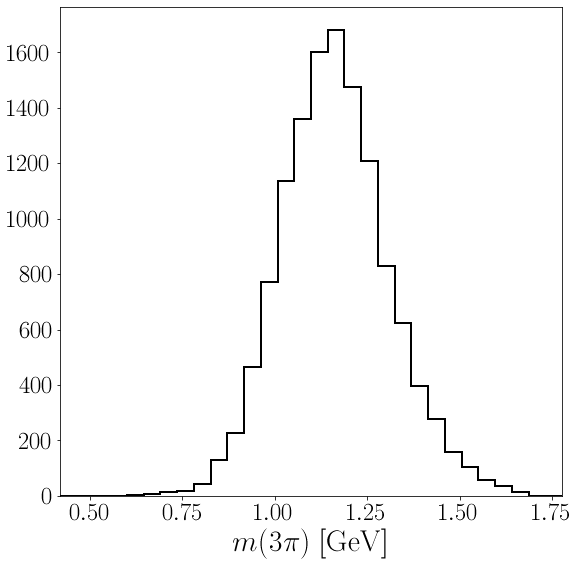

In [15]:
#Plot the tau mass for truth-matched signal
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(ak.flatten(tau["mass"]),range=(tau_m_low_cut_val,tau_m_high_cut_val),bins=30,color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(tau_m_low_cut_val,tau_m_high_cut_val)
plt.xlabel("$m(3\\pi)$ [GeV]",fontsize=30)
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_3pi_M.pdf")

Determine the charged and neutral total energies and multiplicities in the low and high energy hemispheres. Do this by splitting the sample into two, where hemisphere 0 or 1 is the lower energy one. Then grab the charged and neutral variable values for the corresponding hemispheres. At the end recombine the sample.

In [16]:
#Look at charged and neutral multiplicities in the two hemispheres

#Events where hemisphere 0 is the minimum energy
events_hem0_min_cut = events["EVT_thrutshemis0_e"] == events["EVT_thrutshemis_e_min"]
events_hem0_min = events[events_hem0_min_cut]

#Events where hemisphere 1 is the minimum energy
events_hem1_min_cut = events["EVT_thrutshemis1_e"] == events["EVT_thrutshemis_e_min"]
events_hem1_min = events[events_hem1_min_cut]

#Get the charged and neutral energy and multiplicity
for ptype in ["charged","neutral"]:
    for var in ["n","e"]:
        events_hem0_min[f"{var}{ptype}_min"] = events_hem0_min[f"EVT_thrutshemis0_{var}{ptype}"]
        events_hem0_min[f"{var}{ptype}_max"] = events_hem0_min[f"EVT_thrutshemis1_{var}{ptype}"]
        
        events_hem1_min[f"{var}{ptype}_min"] = events_hem1_min[f"EVT_thrutshemis1_{var}{ptype}"]
        events_hem1_min[f"{var}{ptype}_max"] = events_hem1_min[f"EVT_thrutshemis0_{var}{ptype}"]

#Recombine
events = ak.concatenate([events_hem0_min,events_hem1_min],axis=0)

Plot the charged and neutral energies and multiplicities, where the low and high energy hemispheres are shown separately. These plots demonstrate that the signal (low energy) and non-signal sides are different in terms of their full event information. This can be used along with the hemisphere energy and nominal $B$ energy above inside an isolation MVA to distinguish signal from $Z \to q \bar{q}$.

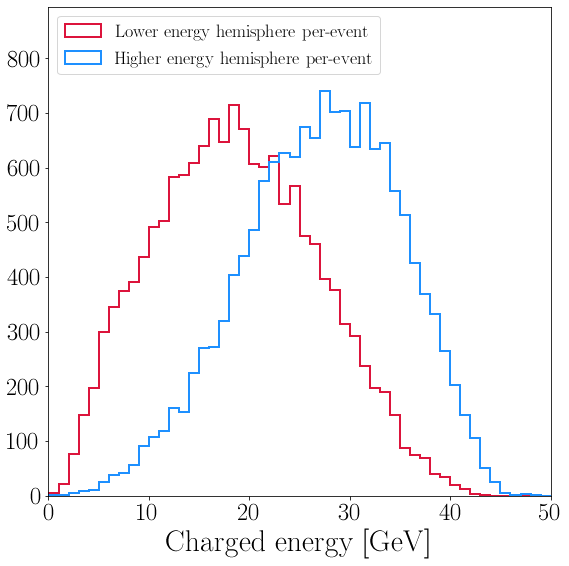

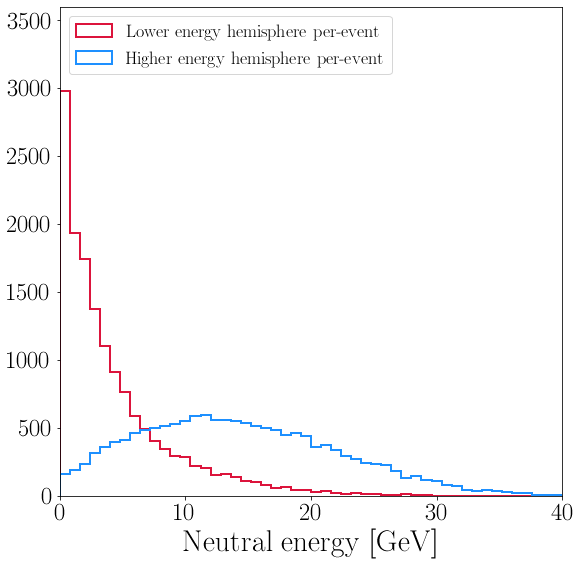

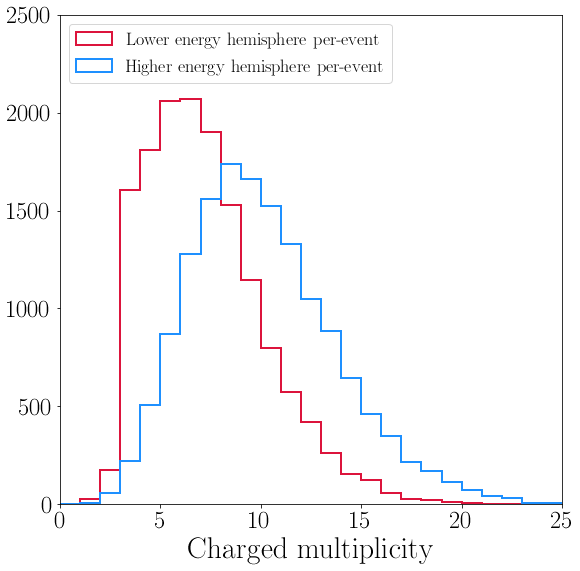

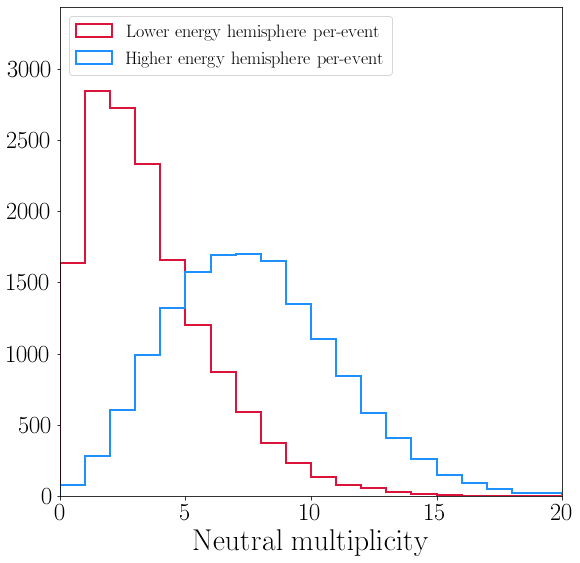

In [17]:
#Axis ranges, titles, and bins
plot_config = {"echarged": [0,50,"Charged energy [GeV]",50],
              "eneutral": [0,40,"Neutral energy [GeV]",50],
              "ncharged": [0,25,"Charged multiplicity",25],
              "nneutral": [0,20,"Neutral multiplicity",20]
              }

for p in plot_config:
    
    #Store the values in the tau container, so we can write it out
    tau[f"{p}_min"] = events[f"{p}_min"]
    tau[f"{p}_max"] = events[f"{p}_max"]

    fig, ax = plt.subplots(figsize=(9,9))
    plt.hist(events[f"{p}_min"],bins=plot_config[p][3],range=(plot_config[p][0],plot_config[p][1]),color="crimson",histtype='step',linewidth=2,label="Lower energy hemisphere per-event")
    plt.hist(events[f"{p}_max"],bins=plot_config[p][3],range=(plot_config[p][0],plot_config[p][1]),color="dodgerblue",histtype='step',linewidth=2,label="Higher energy hemisphere per-event")
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.xlim(plot_config[p][0],plot_config[p][1])
    plt.xlabel(plot_config[p][2],fontsize=30)
    ymin,ymax = plt.ylim()
    plt.ylim(0,1.15*ymax)
    plt.legend(fontsize=18, loc="upper left")
    plt.show()
    fig.savefig(f"{loc.PLOTS}/Bc2TauNu_min_max_hemisphere_{p}.pdf")

Plot the separation of the $\tau$ pion vertex from the PV (a measure of the $B_c$ + $\tau$ flight)

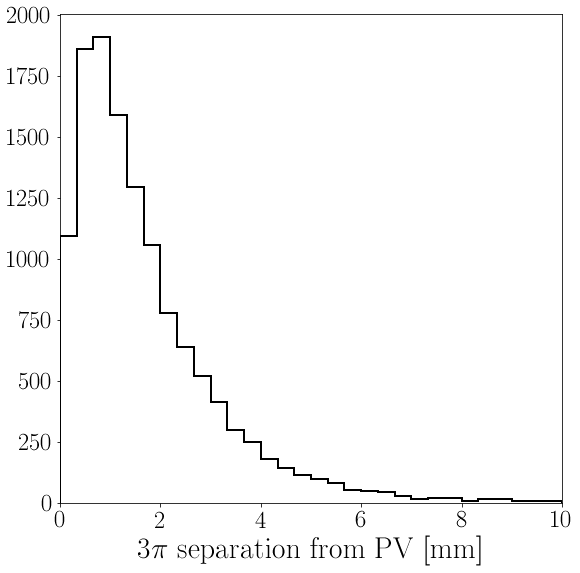

In [18]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(ak.flatten(tau["pi_1","PVsep"]),range=(0,10),bins=30,color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,10)
plt.xlabel("$3\pi$ separation from PV [mm]",fontsize=30)
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_3pi_vertex_PV_sep.pdf")

Plot the separation of the $B_c$ decay vertex from the PV - this quantity cannot be reconstructed experimentally, so will try to use the visible event information to learn it using a regressor

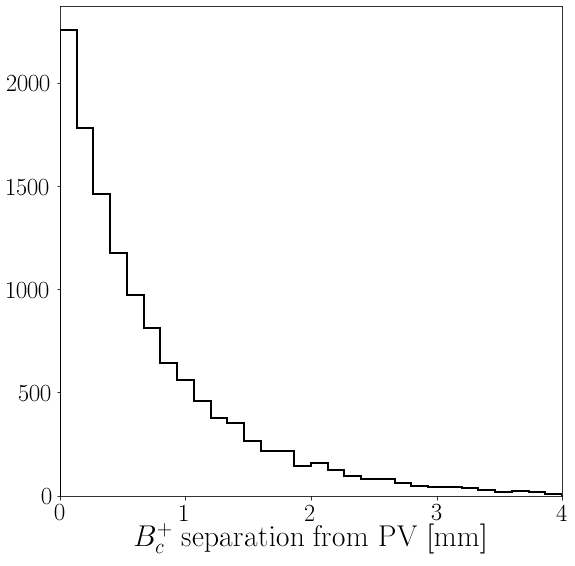

In [19]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(ak.flatten(tau["pi_1","PVsep_parent"]),range=(0,4),bins=30,color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,4)
plt.xlabel("$B_c^+$ separation from PV [mm]",fontsize=30)
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_Bc_vertex_PV_sep.pdf")

Persist information into a flat dataframe for use elsewhere e.g. MVA training vs. $Z -> q\bar{q}$ background

In [20]:
df = pd.DataFrame()
persist_vars = ["EVT_e", #Total event visible energy
                "EVT_thrutshemis_e_min", #Lowest energy hemisphere in event
                "EVT_thrutshemis_e_max", #Highest energy hemisphere in event
                "EVT_thrutshemis0_e", #costheta < 0 hemisphere energy 
                "EVT_thrutshemis1_e", #costheta > 0 hemisphere energy
                "nominal_B_e", #Nominal signal B energy calculated using reco energy of true tau -> 3pi
                "px",
                "py",
                "pz",
                "e",
                "mass",
                "PVsep", #Distance of true tau decay vertex from the PV
                "PVsep_x", 
                "PVsep_y",
                "PVsep_z",
                "PVsep_parent", #Distance of true Bc vertex from the PV (Bc flight which is not reconstructible)
                "EVT_thrust_x",
                "EVT_thrust_y",
                "EVT_thrust_z"
               ]
for var in ["e","n"]:
    for ptype in ["charged","neutral"]:
        for m in ["min","max"]:
            persist_vars.append(f"{var}{ptype}_{m}")


for var in persist_vars:
    df[var] = ak.flatten(tau[var]).tolist()

#Save to CSV
df.to_csv(f"{loc.OUT}/csv/Bc2TauNu.csv")

#Write to ROOT file too
root_file_name = f"{loc.OUT}/ROOT/Bc2TauNu.root"
if os.path.exists(root_file_name):
    os.remove(root_file_name)
df.to_root(root_file_name,"events")